In [1]:
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import gzip
import re

In [4]:
def parse_line(l):
    if l[0] == '#': 
        return None
    if len(l) < 33:
        #print("ERROR: "+l)
        return None
    return {
        "task": re.sub("^ *", "", l[0:16]),
        "pid": int(re.sub(" +$", "", l[17:22])),
        "cpu": int(l[24:27]),
        "irq_off": l[29],
        "need_resched": l[30],
        "hardirq_softirq": l[31],
        "preempt_depth": int(l[32]),
        "timestamp": float(l[33:45]),
        "function": re.sub(":.*", "", l[48:])[:-1],
        "arguments": re.sub("[^:]+:", "", l[48:])[:-1]
    }

In [5]:
def load_log(tracefile):
    with gzip.open(tracefile) as f:
        return [
            line for line in [
            parse_line(line.decode()) 
            for line 
            in f
            ] if line != None
        ]

In [6]:
log = load_log("delay_tracefiles/delay_real_1ms/YCSB_WorkloadA_TimingAsql.log.gz")

In [9]:
set([line["function"] for line in log])

{'block_rq_complete',
 'block_rq_insert',
 'cpufreq_interactive_already',
 'cpufreq_interactive_notyet',
 'cpufreq_interactive_setspeed',
 'cpufreq_interactive_target',
 'sched_switch',
 'tracing_mark_write'}

In [10]:
def extract(trace):
    freq = [
        [ line["timestamp"], line["cpu"], int(re.match(r".*actual=([0-9]+)", line["arguments"])[1]) ]
        for line in trace
        if line["function"].startswith("cpufreq")
    ]
    app = [
        line
        for line in trace
        if line["task"] == "chmark_withjson"
    ]
    query_state = [
        [line["timestamp"], 1 if re.match(".*(SQL_START|DELAY_end)", line["arguments"]) else 0, line["arguments"]]
        for line in app
        if re.match(".*(DELAY_|SQL_)", line["arguments"])
        and line["function"] == "tracing_mark_write"
    ]
    start, end = [
        line["timestamp"]
        for line in log
        if line["function"] == "tracing_mark_write"
        and re.match(".*(a|A)pp", line["arguments"])
    ]
    return [freq, app, query_state, start, end]

In [12]:
freq, app, query_state, start, end = extract(log)

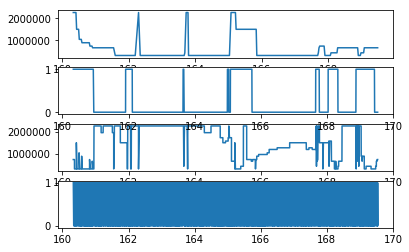

In [13]:
fig = plt.figure()
ax = fig.add_subplot(413)
ax.plot(
    [x[0] for x in freq if x[1] == 0 and x[0] >= start and x[0] <= end],
    [x[2] for x in freq if x[1] == 0 and x[0] >= start and x[0] <= end]
)
ax = fig.add_subplot(411)
ax.plot(
    [x[0] for x in freq if x[1] == 1 and x[0] >= start and x[0] <= end],
    [x[2] for x in freq if x[1] == 1 and x[0] >= start and x[0] <= end]
)
ax = fig.add_subplot(412)
ax.plot(
    [x["timestamp"] for x in app if x["timestamp"] >= start and x["timestamp"] <= end],
    [x["cpu"] for x in app if x["timestamp"] >= start and x["timestamp"] <= end]
)
ax = fig.add_subplot(414)
ax.plot(
    [x[0] for x in query_state],
    [x[1] for x in query_state]
)
plt.show()

In [20]:
def build_trace(log):
    freq, app, query_state, start, end = extract(log)
    return sorted([
        [x[0], { "event" : "freq", "core" : x[1], "freq" : x[2] }]
        for x in freq
    ] + [
        [x["timestamp"], { "event" : "core", "core" : x["cpu"] }]
        for x in app
    ] + [
        [x[0], { "event" : "query", "state" : x[1] == 1 }]
        for x in query_state
    ], key = lambda x : x[0])
trace = build_trace(log)
trace

[[117.76961, {'core': 0, 'event': 'freq', 'freq': 2265600}],
 [117.78961, {'core': 0, 'event': 'freq', 'freq': 2265600}],
 [117.80986, {'core': 0, 'event': 'freq', 'freq': 2265600}],
 [117.82979, {'core': 0, 'event': 'freq', 'freq': 2265600}],
 [117.84965, {'core': 0, 'event': 'freq', 'freq': 2265600}],
 [117.85964, {'core': 1, 'event': 'freq', 'freq': 1036800}],
 [117.8706, {'core': 0, 'event': 'freq', 'freq': 2265600}],
 [117.88962, {'core': 0, 'event': 'freq', 'freq': 2265600}],
 [117.90964, {'core': 1, 'event': 'freq', 'freq': 1036800}],
 [117.91003, {'core': 0, 'event': 'freq', 'freq': 300000}],
 [117.92962, {'core': 0, 'event': 'freq', 'freq': 2265600}],
 [117.9496, {'core': 0, 'event': 'freq', 'freq': 2265600}],
 [117.95965, {'core': 1, 'event': 'freq', 'freq': 300000}],
 [118.00967, {'core': 1, 'event': 'freq', 'freq': 300000}],
 [118.01968, {'core': 0, 'event': 'freq', 'freq': 2265600}],
 [118.03989, {'core': 0, 'event': 'freq', 'freq': 2265600}],
 [118.05962, {'core': 0, 'eve

In [30]:
def compute_cycle_use(trace):
    freq = [2265600, 2265600, 2265600, 2265600]
    app_core = 0
    in_query = False
    last_ts = None
    cumulative_time = 0
    cumulative_cycles = 0
    freq_events = []
    in_query_freq_events = []
    for event in trace:
        ts, desc = event
        if in_query and (not "core" in desc or desc["core"] == app_core):
            delta_ts = ts - last_ts
            cumulative_time += delta_ts
            cumulative_cycles += delta_ts * freq[app_core]
            freq_events.append([ts, freq[app_core]])
        if(desc["event"] == "freq"): 
            freq[desc["core"]] = desc["freq"]
            if in_query:
                in_query_freq_events.append(ts)
        elif(desc["event"] == "core"):
            app_core = desc["core"]
        elif(desc["event"] == "query"):
            in_query = desc["state"]
        else:
            raise "Invlalid event: " +str(desc["event"])
        last_ts = ts
    return [cumulative_time, cumulative_cycles, cumulative_cycles / cumulative_time] 
compute_cycle_use(trace)

[6.3726299999995035, 9907635.8399991, 1554716.9441815815]

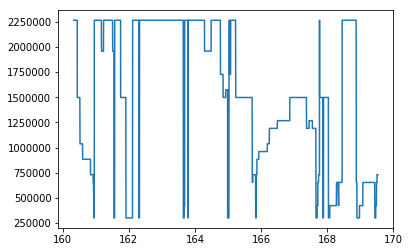

In [16]:
plt.plot([x[0] for x in freq_events], [x[1] for x in freq_events])

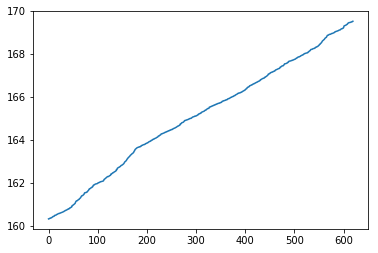

In [19]:
plt.plot(in_query_freq_events)

In [24]:
def load_pair(workload):
    return {
        "real" : load_log("delay_tracefiles/delay_real_1ms/"+workload+".log.gz"),
        "clean" : load_log("delay_tracefiles/delay_clean_1ms/"+workload+".log.gz")
    }

In [32]:
pair_data = load_pair("YCSB_WorkloadB_TimingAsql")

In [34]:
real_stats = compute_cycle_use(build_trace(pair_data["real"]))
clean_stats = compute_cycle_use(build_trace(pair_data["clean"]))
[real_stats, clean_stats]

[[3.728839999999991, 4016552.736000411, 1077158.7775287812],
 [1.938839999999857, 4392635.903999674, 2265599.999999999]]

In [46]:
workloads = [ 
    "YCSB_WorkloadA_TimingA", 
    "YCSB_WorkloadB_TimingA", 
    "YCSB_WorkloadC_TimingA", 
    "YCSB_WorkloadD_TimingA", 
    "YCSB_WorkloadE_TimingA", 
    "YCSB_WorkloadF_TimingA"
]

systems = [
    "sql", "bdb"
]

workload_system_pair_data = [
    [w+s, load_pair(w+s)] for w in workloads for s in systems
]

In [47]:
workload_stats = [ 
    [pair_data[0], [
       compute_cycle_use(build_trace(pair_data[1]["real"])),
       compute_cycle_use(build_trace(pair_data[1]["clean"]))
    ]]
    for pair_data in workload_system_pair_data
]
workload_stats = dict(workload_stats)
workload_stats


[['YCSB_WorkloadA_TimingAsql',
  [[6.3726299999995035, 9907635.8399991, 1554716.9441815815],
   [5.010779999999897, 11352423.167999579, 2265599.9999999623]]],
 ['YCSB_WorkloadA_TimingAbdb',
  [[4.734740000000613, 6160429.056000854, 1301112.4277151555],
   [3.1903799999997204, 7228124.927999375, 2265600.000000003]]],
 ['YCSB_WorkloadB_TimingAsql',
  [[3.728839999999991, 4016552.736000411, 1077158.7775287812],
   [1.938839999999857, 4392635.903999674, 2265599.999999999]]],
 ['YCSB_WorkloadB_TimingAbdb',
  [[4.3974700000005384, 4678283.6880006865, 1063858.0110836716],
   [2.2047800000000137, 4995149.568000022, 2265599.999999996]]],
 ['YCSB_WorkloadC_TimingAsql',
  [[3.573200000000469, 3498465.7920004176, 979084.7957013205],
   [1.5138599999991698, 3429801.215998104, 2265599.9999999898]]],
 ['YCSB_WorkloadC_TimingAbdb',
  [[4.498399999999094, 4658236.703999027, 1035531.9011203905],
   [1.9640400000002955, 4449729.024000716, 2265600.0000000237]]],
 ['YCSB_WorkloadD_TimingAsql',
  [[3.792230

In [54]:
def get_cycles(w):
    return [w[0][1], w[1][1]]

def plot_workload(w):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar([1, 4], get_cycles(workload_stats[w+"sql"]))
    ax.bar([2, 5], get_cycles(workload_stats[w+"bdb"]))
    plt.show()

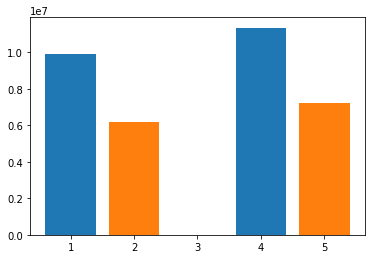

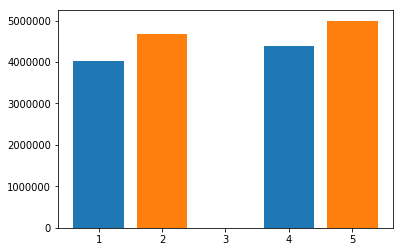

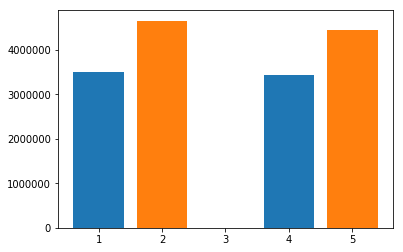

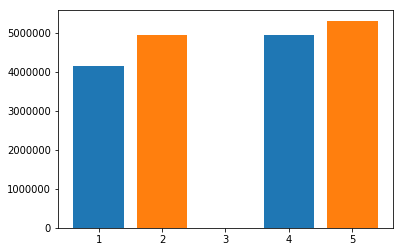

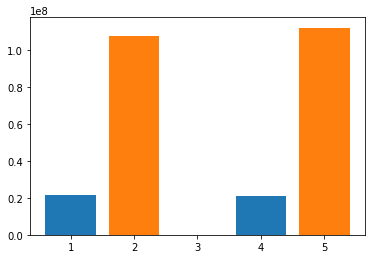

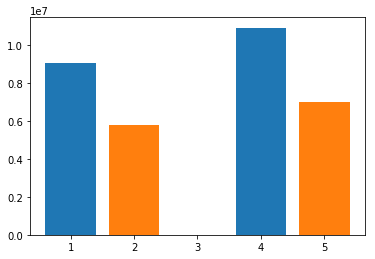

In [58]:
for w in workloads:
    plot_workload(w)

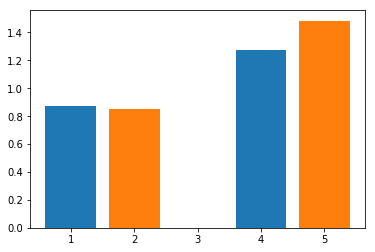

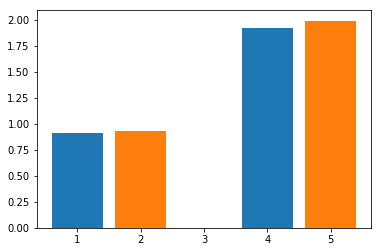

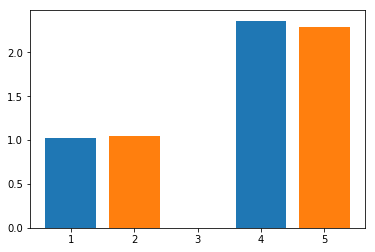

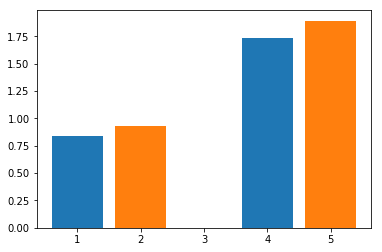

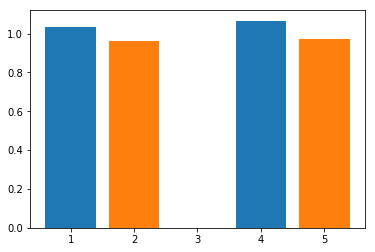

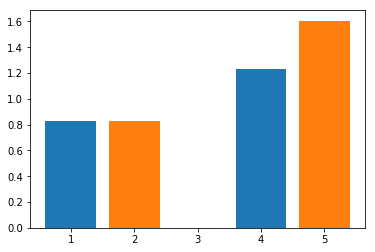

In [63]:
def get_offsets(w):
    return [
        float(w[0][1])/float(w[1][1]), #relative cycles
        float(w[0][0])/float(w[1][0]) #relative time
    ]

def plot_offsets(w):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar([1, 4], get_offsets(workload_stats[w+"sql"]))
    ax.bar([2, 5], get_offsets(workload_stats[w+"bdb"]))
    plt.show()

for w in workloads:
    plot_offsets(w)